In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy

In [42]:
df = pd.read_csv("MSFT.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064384,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400
...,...,...,...,...,...,...,...
9175,2022-08-08,284.049988,285.920013,279.320007,280.320007,280.320007,18739200
9176,2022-08-09,279.640015,283.079987,277.609985,282.299988,282.299988,23405200
9177,2022-08-10,288.170013,289.809998,286.940002,289.160004,289.160004,24687800
9178,2022-08-11,290.850006,291.209991,286.510010,287.019989,287.019989,20065900


Next I converted the dates (strings) to date objects. Without this, matplotlib fails to plot dates and corresponding closing stock prices.

In [43]:
# function to make date strings to date objects
def to_datetime(str):
  split = str.split('-')
  year = int(split[0])
  month = int(split[1])
  day = int(split[2])
  # year, month, day = str.split('-') # won't work cuz type needs to be int
  
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(to_datetime)

Now a plot of the dates and closing prices.

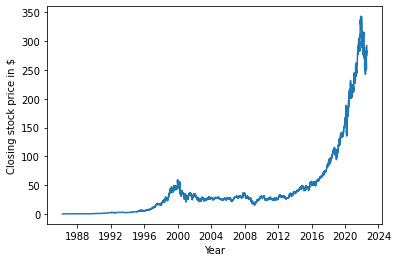

<Figure size 720x720 with 0 Axes>

In [44]:
# making dates the index instead of those numbers
df.index = df.pop("Date")

# plotting the graph
plt.plot(df.index, df["Close"])
plt.xlabel("Year")
plt.ylabel("Closing stock price in $")
plt.figure(figsize=(10, 10))
plt.show()

Setting up for Machine Learning- 389 and 348

Since this is an LSTM problem, I windowed the dataframe as a windowed dataframe makes it better for machine learning. This way I can use optimization tools later in the problem and even forecast.

Once the dataframe has n windows, they can be converted to numpy arrays of inputs and observations to train, validate, and test.

In [45]:
def window(dataframe, start_date, end_date, n):

  '''
  given the starting date, end date, and the number of windows we need.
  we go back n dates from the starting date and add the stock price of each day to the array
  (so the number of windows can't be more than the possible dates)
  so we will have the values of previous days and that day
  go on till the end date

  basically for each date, get the closing value of that date and the previous n dates

  inputs :
    dataframe: the given dataframe
    start_date : string
                  date to begin windowing on
    end_date : string
                  date to end windowing on
    n : number of windows
  
  output :
    a revised and shorter df with n number of days off the target date
    each date also shows the closing stock price on that day

    x : np.ndarray
        An array of shape (m) where each row is a different set of features
    y : np.ndarray
        The true value of the input
  '''

  first_date = to_datetime(start_date)
  last_date  = to_datetime(end_date)

  current_date = first_date
  
  dates, X, Y = [], [], []

  last_time = False
  while True:
    # the subset should contail everything till the target date
    df_subset = dataframe.loc[:current_date].tail(n+1)
    
    # in case the date n days before the current date isn't in the dataset
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {current_date}')
      return

    values = df_subset['Close'].to_numpy() # numpy array of closing values
    x = values[:-1] # x will be all up till the current date
    y = values[-1] # y is the current (target) date

    # adding the above stuff to their respective arrays
    dates.append(current_date)
    X.append(x)
    Y.append(y)

    # data for the following week ranges from the current date to current date + 7 days
    next_week = dataframe.loc[current_date: current_date + (datetime.timedelta(days=7))]
    next_datetime = str(next_week.head(2).tail(1).index.values[0])

    # assigning year, month, day, and setting up the next date
    next_date_split = next_datetime.split('T')[0]
    year, month, day = next_date_split.split('-')
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    current_date = next_date

    if current_date == last_date:
      last_time = True
    
  
  revised_df = pd.DataFrame({})
  revised_df['Current Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    revised_df[f'Value on Target-{n-i} Days'] = X[:, i]
  
  revised_df['Closing value on this date'] = Y

  return revised_df


In [46]:
# testing out the above function
windowed_df = window(df, '1986-03-19', '2022-03-23', n=4)
windowed_df

,Current Date,Value on Target-4 Days,Value on Target-3 Days,Value on Target-2 Days,Value on Target-1 Days,Closing value on this date
0,1986-03-19,0.097222,0.100694,0.102431,0.099826,0.098090
1,1986-03-20,0.100694,0.102431,0.099826,0.098090,0.095486
2,1986-03-21,0.102431,0.099826,0.098090,0.095486,0.092882
3,1986-03-24,0.099826,0.098090,0.095486,0.092882,0.090278
4,1986-03-25,0.098090,0.095486,0.092882,0.090278,0.092014
...,...,...,...,...,...,...
9073,2022-03-17,280.070007,276.440002,287.149994,294.390015,295.220001
9074,2022-03-18,276.440002,287.149994,294.390015,295.220001,300.429993
9075,2022-03-21,287.149994,294.390015,295.220001,300.429993,299.160004
9076,2022-03-22,294.390015,295.220001,300.429993,299.160004,304.059998


Converting to numpy arrays so we can send to tensorflow.

Could have included this part in the above function but looking at the above df helps understand better.

Then plotting it to see what part of the data will be used for training, validating, testing

In [47]:
def windowed_numpy(windowed_dataframe):
  
  '''
   x : np.ndarray
        An array of shape (m) where each row is a different set of features
   y : np.ndarray
        The true value of the input
  '''
  df_as_np = windowed_dataframe.to_numpy() # converting the above dataframe to a numpy array

  dates = df_as_np[:, 0] # all rows, first column

  # the middle matrix includes all rows, get all "input" columns (target-1 etc)
  middle_matrix = df_as_np[:, 1:-1]
  # fixing the shape
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  # all rows, last column
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32) # these are all numpy arrays

dates, X, y = windowed_numpy(windowed_df)

# dates.shape, X.shape, y.shape # if want to check the shape

Splitting the data for training, validation, and testing.

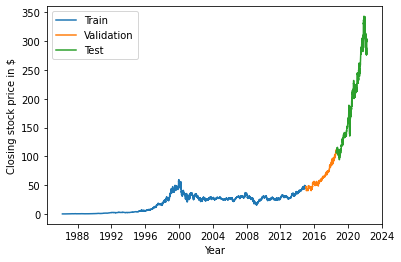

In [48]:
# split points at 80% and 90%
split_80 = int(len(dates) * .8)
split_90 = int(len(dates) * .9)

# training data- on 80% of the data
dates_train = dates[:split_80]
X_train = X[:split_80]
y_train = y[:split_80]

# validation data- on 80-90% of the data
dates_val = dates[split_80:split_90]
X_val = X[split_80:split_90]
y_val = y[split_80:split_90]

# testing data- on remaining 10% of the data
dates_test = dates[split_90:]
X_test = X[split_90:]
y_test = y[split_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.xlabel("Year")
plt.ylabel("Closing stock price in $")
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

Beginning Machine Learning

In [49]:
# Setting up the model- see 389

# if (3, 1) is the shape of our input- 3 days in the past, 1 feature
# so in the current case, layers.Input(())
# LSTM number is how complex we want the model- high number = high complexity
# relu activation function with a bunch of layers
# final Dense(1) as we are forecasting one value

model = Sequential([
    layers.Input((4, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="linear"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="linear"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

# compliling the model- see 348
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["mean_absolute_error"])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
227/227 [==============================] - 4s 8ms/step - loss: 70.0385 - mean_absolute_error: 3.4358 - val_loss: 381.7166 - val_mean_absolute_error: 12.5192
Epoch 2/100
227/227 [==============================] - 1s 6ms/step - loss: 0.4769 - mean_absolute_error: 0.4070 - val_loss: 313.3986 - val_mean_absolute_error: 10.8592
Epoch 3/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3994 - mean_absolute_error: 0.3685 - val_loss: 282.7083 - val_mean_absolute_error: 10.2481
Epoch 4/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3666 - mean_absolute_error: 0.3595 - val_loss: 245.0593 - val_mean_absolute_error: 9.2581
Epoch 5/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3432 - mean_absolute_error: 0.3487 - val_loss: 231.9663 - val_mean_absolute_error: 9.0003
Epoch 6/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3450 - mean_absolute_error: 0.3513 - val_loss: 214.9936 - val_mean_absolute_error: 8

Validation mean absolute error goes down, then hovers around 7 towards the end (8 sometimes)

Plot on different code blocks so everything doesn't plot together

Plotted together after

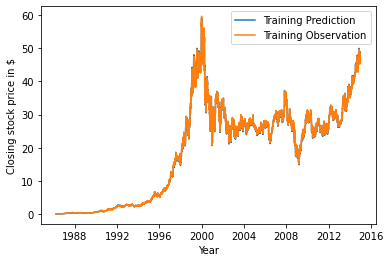

In [50]:
# training predictions- need to flatten this one
predictions_train = model.predict(X_train).flatten()

# plot for training data
plt.plot(dates_train, predictions_train)
plt.plot(dates_train, y_train)
plt.xlabel("Year")
plt.ylabel("Closing stock price in $")
plt.legend(["Training Prediction", "Training Observation"])
plt.show()
# This model is quite accurate as the predictions are very close to the actual observations

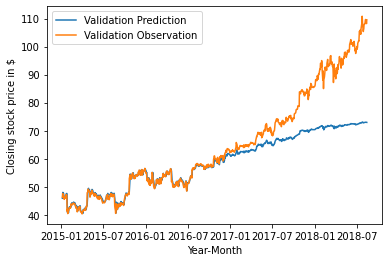

In [51]:
# validation predictions
predictions_val = model.predict(X_val)

# plot for validation data
plt.plot(dates_val, predictions_val)
plt.plot(dates_val, y_val)
plt.xlabel("Year-Month")
plt.ylabel("Closing stock price in $")
plt.legend(["Validation Prediction", "Validation Observation"])
plt.show()
# this model was accurate till 2017 and then it went completely off

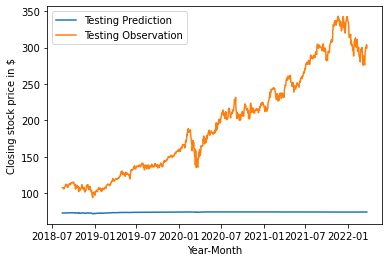

In [52]:
# testing predictions
predictions_test = model.predict(X_test)

# plot for testing data
plt.plot(dates_test, predictions_test)
plt.plot(dates_test, y_test)
plt.xlabel("Year-Month")
plt.ylabel("Closing stock price in $")
plt.legend(["Testing Prediction", "Testing Observation"])
plt.show()
# this model was not even close since the beginning

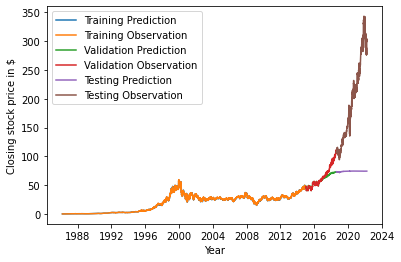

In [53]:
# plotting everything together

# plot for training data
plt.plot(dates_train, predictions_train)
plt.plot(dates_train, y_train)

# plot for validation data
plt.plot(dates_val, predictions_val)
plt.plot(dates_val, y_val)

# plot for testing data
plt.plot(dates_test, predictions_test)
plt.plot(dates_test, y_test)

plt.xlabel("Year")
plt.ylabel("Closing stock price in $")
plt.legend(["Training Prediction", "Training Observation",
            "Validation Prediction", "Validation Observation",
            "Testing Prediction", "Testing Observation"])
plt.show()

Since the model stops being accurate towards the end, it is possible that all the older data isn't as useful.

So I used only the previous year's data to train the model and test its accuracy by altering our windowed_df variable to start on a newer date.

If the new date is too close to the last date, the errors aren't really reduced and the plot for even training isn't accurate- plots even have gaps in them.

If the new date is too far from the last date, the validation and testing plots work better than before but still not good.

In [54]:
# new starting date
revised_windowed_df = window(df, '2021-01-24', '2022-03-23', n=4)

revised_windowed_df

,Current Date,Value on Target-4 Days,Value on Target-3 Days,Value on Target-2 Days,Value on Target-1 Days,Closing value on this date
0,2021-01-24,212.649994,216.440002,224.339996,224.970001,225.949997
1,2021-01-26,224.339996,224.970001,225.949997,229.529999,232.330002
2,2021-01-27,224.970001,225.949997,229.529999,232.330002,232.899994
3,2021-01-28,225.949997,229.529999,232.330002,232.899994,238.929993
4,2021-01-29,229.529999,232.330002,232.899994,238.929993,231.960007
...,...,...,...,...,...,...
289,2022-03-17,280.070007,276.440002,287.149994,294.390015,295.220001
290,2022-03-18,276.440002,287.149994,294.390015,295.220001,300.429993
291,2022-03-21,287.149994,294.390015,295.220001,300.429993,299.160004
292,2022-03-22,294.390015,295.220001,300.429993,299.160004,304.059998


Then I repeated the above steps to get revised accuracies and revised plots.

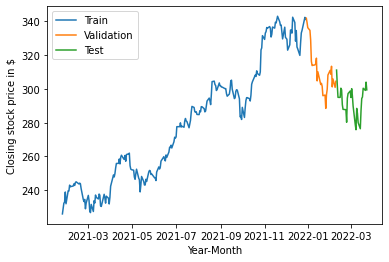

In [55]:
# all the data we made above but for the revised dates
revised_dates, revised_X, revised_y = windowed_numpy(revised_windowed_df)

r_split_80 = int(len(revised_dates) * .8)
r_split_90 = int(len(revised_dates) * .9)

# training data- on 80% of the data
r_dates_train = revised_dates[:r_split_80]
r_X_train = revised_X[:r_split_80]
r_y_train = revised_y[:r_split_80]

# validation data- on 80-90% of the data
r_dates_val = revised_dates[r_split_80:r_split_90]
r_X_val = revised_X[r_split_80:r_split_90]
r_y_val = revised_y[r_split_80:r_split_90]

# testing data- on remaining 10% of the data
r_dates_test = revised_dates[r_split_90:]
r_X_test = revised_X[r_split_90:]
r_y_test = revised_y[r_split_90:]

plt.plot(r_dates_train, r_y_train)
plt.plot(r_dates_val, r_y_val)
plt.plot(r_dates_test, r_y_test)

plt.xlabel("Year-Month")
plt.ylabel("Closing stock price in $")
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

Since the model itself is fine we can run it

In [56]:
model.fit(r_X_train, r_y_train, validation_data=(r_X_val, r_y_val), epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 14ms/step - loss: 21611.1816 - mean_absolute_error: 129.2803 - val_loss: 5843.2974 - val_mean_absolute_error: 75.2540
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 6266.6743 - mean_absolute_error: 65.6355 - val_loss: 8780.5547 - val_mean_absolute_error: 92.7384
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 3658.7830 - mean_absolute_error: 50.2857 - val_loss: 610.9725 - val_mean_absolute_error: 20.8972
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 2212.6829 - mean_absolute_error: 39.9740 - val_loss: 1076.0859 - val_mean_absolute_error: 29.9326
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 1669.1700 - mean_absolute_error: 33.3919 - val_loss: 2336.8179 - val_mean_absolute_error: 46.4408
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 1204.9232 - mean_absolute_error: 29.8247 - val_loss: 954.9742 - val_mean_absolute_

Much better results for the errors. Lowest I recorded was 4.

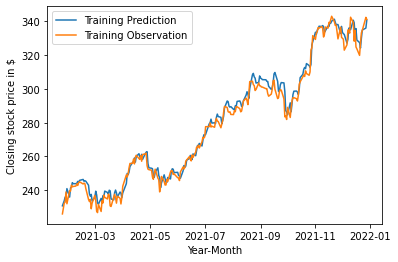

In [57]:
# training predictions
r_predictions_train = model.predict(r_X_train).flatten()

# plot for training data
plt.plot(r_dates_train, r_predictions_train)
plt.plot(r_dates_train, r_y_train)

plt.xlabel("Year-Month")
plt.ylabel("Closing stock price in $")
plt.legend(["Training Prediction", "Training Observation"])
plt.show()
# predictions are still good

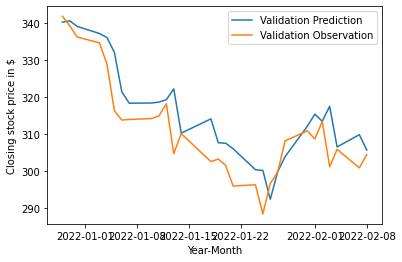

In [58]:
# validation predictions
r_predictions_val = model.predict(r_X_val)

# plot for validation data
plt.plot(r_dates_val, r_predictions_val)
plt.plot(r_dates_val, r_y_val)
plt.xlabel("Year-Month")
plt.ylabel("Closing stock price in $")
plt.legend(["Validation Prediction", "Validation Observation"])
plt.show()
# results are way better this time

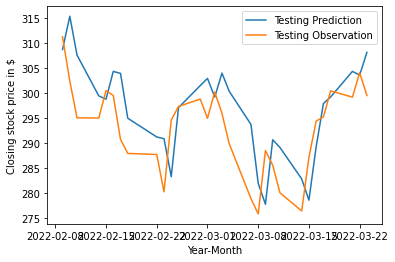

In [59]:
# testing predictions
r_predictions_test = model.predict(r_X_test)

# plot for testing data
plt.plot(r_dates_test, r_predictions_test)
plt.plot(r_dates_test, r_y_test)
plt.xlabel("Year-Month")
plt.ylabel("Closing stock price in $")
plt.legend(["Testing Prediction", "Testing Observation"])
plt.show()
# much better results than before

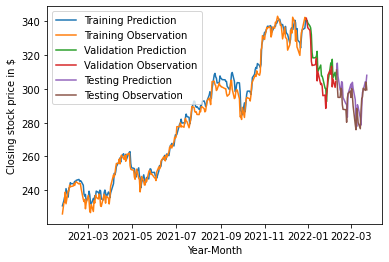

In [60]:
# plotting everything together

# plot for training data
plt.plot(r_dates_train, r_predictions_train)
plt.plot(r_dates_train, r_y_train)

# plot for validation data
plt.plot(r_dates_val, r_predictions_val)
plt.plot(r_dates_val, r_y_val)

# plot for testing data
plt.plot(r_dates_test, r_predictions_test)
plt.plot(r_dates_test, r_y_test)

plt.xlabel("Year-Month")
plt.ylabel("Closing stock price in $")
plt.legend(["Training Prediction", "Training Observation",
            "Validation Prediction", "Validation Observation",
            "Testing Prediction", "Testing Observation"])
plt.show()

Now forecasting

In [62]:
# revised predictions and dates
r_predictions = []
r_dates = np.concatenate([r_dates_val, r_dates_test])

for target_date in r_dates:
  # most recent input (window of last 3 dates)
  last_window = deepcopy(r_X_train[-1])
  # next prediction- prediction of the next day
  next_prediction = model.predict(np.array([last_window])).flatten()
  # adding the next prediction to the list of recursive prediction
  r_predictions.append(next_prediction)
  # updating the last window to the previous 2 infos + the newly predicted value
  last_window[-1] = next_prediction


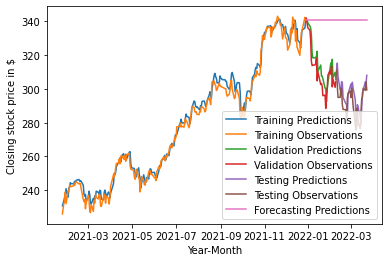

<Figure size 720x720 with 0 Axes>

In [63]:
# and now plotting all that
plt.plot(r_dates_train, r_predictions_train)
plt.plot(r_dates_train, r_y_train)
plt.plot(r_dates_val, r_predictions_val)
plt.plot(r_dates_val, r_y_val)
plt.plot(r_dates_test, r_predictions_test)
plt.plot(r_dates_test, r_y_test)
plt.plot(r_dates, r_predictions)

plt.xlabel("Year-Month")
plt.ylabel("Closing stock price in $")
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Forecasting Predictions'])

plt.figure(figsize=(10, 10))
plt.show()

So the forecasting wasn't useful for the long term but for a day to day use case it isn't too bad despite being a straight line. Forecast would be better if I include more features to train with instead of just closing stock prices.